# Desafio Manipulaê
### Candidato: Ivan Berlim Gonçalves

#### Resumo do desafio

Com pouco tempo para realizar o desafio e com objetivo principal de prever os valores das formulações, eu fui direto ao ponto através dos seguintes passos:
- Primeiramente eu analisei e limpei a coluna `descricao`, com objetivo de separa a quantidade de capsulas, insumos e quandidade por insumo utilizando Regular Expressions.
- Após este procedimento inicial, eu criei um DataFrame com os nomes dos insumos como colunas e suas respectivas quantidades como valores das instâncias, criando uma matriz com os respectivos valores dos insumos por instância.
- Como a matriz resultou em muitas colunas, selecionei apenas as 50 com mais correlação ao preço correto e iniciei os treinamentos dos modelos.
- Calculei as métricas de performance dos modelos e criei uma matriz e um gráfico comparando a performance dos diferentes algoritmos de Machine Learning
- Por fim, adicionei os resultados a um DataFrame para análise dos resultados finais.

Neste desafio eu utilizei 7 algoritmos de machine learning para prever o preço dos medicamentos: Regressão Linear,Gradient Boost,Decision Tree,Support Vector Machine,Random Forest,Neural Network e XGBoost.

##### Resultados
Os modelos de Gradiente (Gradient Boost e XGBoost) foram os que apresentaram melhores métricas de desempenho para o tipo de análise realizado.<br/>
* O modelo Gradient Boost apresentou MAE de 62,93 e R2 score de 0,078
* Enquanto o modelo XGBoost apresentou MAE de 59,43 e R2 score de 0,092.

Portanto, o modelo XGBoost ainda se destacou ligeiramente sobre o Gradient Boost.

##### Considerações e aprendizados
Como engenheiro e recém chegado no mundo da ciência de dados, este desafio trouxe muito conhecimento de aplicação de diversas técnicas em dados do mundo real. Este projeto me agregou muito conhecimento principalmente sobre Regular Expressions, que ainda não tinha tido um contato mais profundo, e com modelos de Machine Learning propriamente dito.

Em relação ao trabalho, acho que a preparação dos dados ficou boa. Claro, sempre podemos melhorar, mas julgando o tempo e o desafio, acho que foi um bom trabalho. Porém pequei muito nos ajustes dos modelos, muito devido a falta de tempo. Poderia ter feito um preprocessamento melhor e ajustado hiperparâmetros para obter melhores resultados.

<br/><br/>
## Problema de negócio
Prever o valor correto de 7121 formulas de medicamentos manipulados usando algoritmos de Machine Learning.

## Coleta de dados
Os dados foram fornecidos pela Manipulaê em um arquivo csv (link: https://raw.githubusercontent.com/manipulaeHealth/desafio-machine-learning/main/dados_preco.csv).

**Informações dos dados:**

descrição da formula, seguindo o padrão:

qtd unidade_volume | insumos separados por ';' 

a unidade de volume vai ser sempre CAP no dataset 

os insumos vão ter o padrão: 
    nome do insumo qtdunidade;  

    ex: zinco quelado 20mg; 

Importação das bibliotecas que serão usadas.
<br/><br/>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import re
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import nltk

<br/><br/>
Leitura do arquivo `dados_preco.csv` para o DataFrames `data` e exibição do DataFrame
<br/><br/>

In [2]:
# Leitura do endereço do arquivo csv e criação do DataFrame 'data'
caminho = "https://raw.githubusercontent.com/manipulaeHealth/desafio-machine-learning/main/dados_preco.csv"
data = pd.read_csv(caminho)
data.head()

,descricao,criado,qtdInsumos,calculado,correto
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,2020-08-05 23:19:09,1,47.5297,39.9
1,60 CAP | FINASTERIDA 1:10 1MG,2020-08-05 22:51:09,1,46.9620,43.6
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,2020-08-05 22:51:09,3,105.1390,111.4
3,60 CAP | ANASTROZOL 1:10 0.300MG,2020-08-05 22:51:09,1,49.0314,43.6
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2020-08-05 22:49:09,2,161.8272,146.0


<br/><br/>
## Análise Exploratória e Preparação de Dados

Descrições e informações do arquivo `data`
<br/><br/>

In [3]:
print(data.describe())
print('\n --------------------------------------------- \n')
print(data.info())

        qtdInsumos     calculado       correto
count  7121.000000   7121.000000   7121.000000
mean      3.281842    137.089552    135.891798
std       3.194301    191.266516    189.806974
min       1.000000     30.000100     33.000000
25%       1.000000     49.786100     49.500000
50%       2.000000     87.350300     83.100000
75%       4.000000    165.167000    161.200000
max      26.000000  10364.992500  10356.000000

 --------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7121 entries, 0 to 7120
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   descricao   7121 non-null   object 
 1   criado      7121 non-null   object 
 2   qtdInsumos  7121 non-null   int64  
 3   calculado   7121 non-null   float64
 4   correto     7121 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 278.3+ KB
None


<br/><br/>
Criação do DataFrame `df` que terá informações utilizadas para Feature Engineering e treinamento do modelo, evitando também assim uma eventual modificação acidental dos dados do dataframe `data`
<br/><br/>

In [4]:
# Cria o DataFrame 'df' e copia as colunas 'descricao', 'qtdInsumos', 'calculado' e 'correto'
df = pd.DataFrame()
df = data[['descricao', 'qtdInsumos', 'calculado', 'correto']].copy()

<br/><br/>
Criação de uma coluna `qtd_cap` no `df` que representa a quantidade de capsulas de cada instância
<br/><br/>

In [5]:
# Loop para separar a string em espaços ' ' e adiciona o primeiro split à lista 'qtd_cap'
lst = []
qtd_cap = []
for descricao in df.descricao:
    lst = descricao.split(" ")
    qtd_cap.append(lst[0])

# Adiciona a lista 'qtd_cap', com o número de capsulas, à coluna 'qtd_cap' do dataframe 'df'
df["qtd_cap"] = qtd_cap
df['qtd_cap'] = pd.to_numeric(df["qtd_cap"], downcast="float")

<br/><br/>
Criação uma lista `lst_componentes` de componentes utilizados nas instâncias, separada por `;` e adiciona uma coluna `componentes` ao DataFrame `df`
<br/><br/>

In [6]:
# Loop para limpar as strings da coluna 'descricao' no DataFrame 'df'
lst_componentes=[]
for s in df['descricao']:
    
    # Remover as pontuações (exceto o caractere ';')
    s=re.sub(r'[^\w\s;]','',s)
    
    # Remover as unidades
    s=re.sub(r"(\d\w*)", "", s)
    
    # Remove os dígitos
    s=re.sub(r"(\d)", "", s)
    
    # Remove eventual conteúdo entre parênteses
    s=re.sub(r'\([^)]*\)', '', s)
    
    # Conversão para letras minúsculas
    s=s.lower()
    
    # Remove a palavra 'cap'
    s=re.sub(r"cap", "", s)
    
    # Remover espaços duplos e triplos entre as palavras
    s=re.sub(r"(\s\s\s)", " ", s)
    s=re.sub(r"(\s\s)", " ", s)
    s=re.sub(r"  ", "5htp", s)
    
    # Adiciona os componentes à lista 'lst_componentes'
    lst_componentes.append(s)
    
# Adiciona a lista 'lst_componentes' como coluna 'componentes' ao DataFrame 'df'
df['componentes'] = lst_componentes

<br/><br/>
Verificação de quantos componentes únicos existem. Isto é útil para ter uma ideia de quantas colunas serão criadas.
No caso, existem 1501 componentes únicos e, portanto, serão necessárias 1501 colunas para representar os componentes com suas variadas quantidades a depender das diferentes instâncias.
<br/><br/>

In [7]:
# Loop para verificar quantos componentes únicos existem na coluna 'componentes', do DataFrame 'df'
lst = []
componentes_unicos = set()
for words in lst_componentes:
    lst = words.split(";")
    for item in lst:
        componentes_unicos.add(item.strip())

# Imprimir o tamanho da lista de componentes
len(componentes_unicos)

1501

<br/><br/>
Criação de uma coluna `qtd` no DataFrame `df` que representa a quantidade dos componentes, separados por ';'
<br/><br/>

In [8]:
# Criando uma coluna 'qtd' que representa a quantia dos componentes, separada por ;
lst_quantidade=[]
s=[]
for s in df['descricao']:
    
    # Remove a quantidade de capsulas, removendo os primeiros 3 valores das strings na coluna 'descrição'
    sliced = s[3:]
    
    # Remove proporções
    s = re.sub(r'\d:\d\d', '', sliced)
    
    # Remove pontuações (exceto ; e .)
    s=re.sub(r'[^\d;.]','',s)
    
    # Remove eventual conteúdo entre parênteses
    s=re.sub(r'\([^)]*\)', '', s)
    
    # Adiciona as quantidades à lista 'lst_quantidade'
    lst_quantidade.append(s)

# Adiciona a lista 'lst_quantidade' como coluna 'qtd' ao DataFrame 'df'
df['qtd'] = lst_quantidade
lst_quantidade[0:5]

['150', '1', '250;150;50', '0.300', '0.250;10']

<br/><br/>
Criação de um dicionário `dict_comp_qtd` que associa a descrição (como chave) com a quantidade (como valor)
<br/><br/>

In [9]:
# Loop para separar a 'lst_componentes' por ';' e adicionar o resultado à lista 'lst_comp'
lst_comp = []
for i in lst_componentes:
    lst_comp.append(i.split(';'))
    
# Loop para separar a 'lst_quantidade' por ';' e adicionar o resultado à lista 'lst_qtd'
lst_qtd = []
for i in lst_quantidade:
    lst_qtd.append(i.split(';'))

# Criação da lista 'dict_comp_qtd' que recebe o zip duplo que associa o componente e a quantidade como um dicionário 
dict_comp_qtd = [dict(zip(*z)) for z in zip(lst_comp, lst_qtd)]

print(dict_comp_qtd)

[{' bupropiona cloridrato ': '150'}, {' finasterida ': '1'}, {' nac ': '250', ' silimarina ': '150', ' same ': '50'}, {' anastrozol ': '0.300'}, {' dutasterida ': '0.250', ' tadalafil ': '10'}, {' triiodotironina slow release ': '12'}, {' t ': '460'}, {' vitamina b ': '1260', ' acido folico ': '3', ' zinco quelado ': '30', ' selenio quelado ': '200', ' magnesio quelado ': '30400', ' picolinato de cromo ': '1000', ' saw palmeto ext seco ': '200', ' espironolactona ': '100', ' pygeum africanum ext seco ': '.100', ' finasterida ': '0.500'}, {' cortisol ': '20', ' prasterona ': '20'}, {' tadalafil ': '10', ' arginina ': '2'}, {' gestrinona ': '2'}, {' magnesio quelado ': '30200', ' coenzima q po ': '10100'}, {' silimarina ': '200', ' vitamina b ': '6100', ' acido folico ': '2.500', ' nac ': '200'}, {' vitamina d ': '10000', ' vitamina k mk ': '27100'}, {' oxandrolona ': '20'}, {' bupropiona cloridrato ': '150'}, {' triiodotironina slow release ': '10'}, {' clomifeno citrato ': '100', ' tad

<br/><br/>
Criação do dataframe `df1` a partir da lista de dicionários `dict_comp_qtd` e substituição de valores `NaN` por 0 (zero)
<br/><br/>

In [10]:
# Criação de 'df1'
df1 = pd.DataFrame(dict_comp_qtd)

# Transformação do tipo de dado de 'df1' para float64
df1 = df1.apply(pd.to_numeric, errors='coerce')

# Substituição de valores NaN por 0 (zero) 'df1 = df1.fillna(0)''
column_means = df1.mean()
df1 = df1.fillna(column_means)

df1.head()

,bupropiona cloridrato,finasterida,nac,silimarina,same,anastrozol,dutasterida,tadalafil,triiodotironina slow release,t,...,glicerina,aloe vera ext glicolico,pcana,gentamicina sulfato,base creme,dlfenilalanina,bacteroides fragilis,andarine,lprolina,trimetilxantina microensula
0,150.000000,2.334783,237.701149,213.482759,209.285714,20.623684,0.433333,5.55,9.7625,212.563877,...,5.0,2.0,1.0,0.3,60.0,500.0,100.0,50.0,100.0,90.0
1,134.745763,1.000000,237.701149,213.482759,209.285714,20.623684,0.433333,5.55,9.7625,212.563877,...,5.0,2.0,1.0,0.3,60.0,500.0,100.0,50.0,100.0,90.0
2,134.745763,2.334783,250.000000,150.000000,50.000000,20.623684,0.433333,5.55,9.7625,212.563877,...,5.0,2.0,1.0,0.3,60.0,500.0,100.0,50.0,100.0,90.0
3,134.745763,2.334783,237.701149,213.482759,209.285714,0.300000,0.433333,5.55,9.7625,212.563877,...,5.0,2.0,1.0,0.3,60.0,500.0,100.0,50.0,100.0,90.0
4,134.745763,2.334783,237.701149,213.482759,209.285714,20.623684,0.250000,10.00,9.7625,212.563877,...,5.0,2.0,1.0,0.3,60.0,500.0,100.0,50.0,100.0,90.0


<br/><br/>
Criação do DataFrame `dff` que é a junção dos DataFrames `df` e `df1`
<br/><br/>

In [11]:
# Concatenação entre 'df' e 'df1'
dff = pd.concat([df, df1], axis=1, join='inner')

dff.head()

,descricao,qtdInsumos,calculado,correto,qtd_cap,componentes,qtd,bupropiona cloridrato,finasterida,nac,...,glicerina,aloe vera ext glicolico,pcana,gentamicina sulfato,base creme,dlfenilalanina,bacteroides fragilis,andarine,lprolina,trimetilxantina microensula
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,1,47.5297,39.9,30.0,bupropiona cloridrato,150,150.000000,2.334783,237.701149,...,5.0,2.0,1.0,0.3,60.0,500.0,100.0,50.0,100.0,90.0
1,60 CAP | FINASTERIDA 1:10 1MG,1,46.9620,43.6,60.0,finasterida,1,134.745763,1.000000,237.701149,...,5.0,2.0,1.0,0.3,60.0,500.0,100.0,50.0,100.0,90.0
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,3,105.1390,111.4,60.0,nac ; silimarina ; same,250;150;50,134.745763,2.334783,250.000000,...,5.0,2.0,1.0,0.3,60.0,500.0,100.0,50.0,100.0,90.0
3,60 CAP | ANASTROZOL 1:10 0.300MG,1,49.0314,43.6,60.0,anastrozol,0.300,134.745763,2.334783,237.701149,...,5.0,2.0,1.0,0.3,60.0,500.0,100.0,50.0,100.0,90.0
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2,161.8272,146.0,120.0,dutasterida ; tadalafil,0.250;10,134.745763,2.334783,237.701149,...,5.0,2.0,1.0,0.3,60.0,500.0,100.0,50.0,100.0,90.0


<br/><br/>
Descarte das colunas `descrição`, `componentes`, `calculado` e `qtd` (e `qtdInsumos`) do DataFrame para treinamento `dff`
<br/><br/>

In [12]:
# Descarte das colunas
dff = dff.drop(['descricao'],axis=1)
dff = dff.drop(['componentes'],axis=1)
dff = dff.drop(['calculado'],axis=1)
dff = dff.drop(['qtd'],axis=1)
# dff = dff.drop(['qtdInsumos'],axis=1)

# Transformação dos tipos de dados de 'dff' para float64
dff = dff.apply(pd.to_numeric, errors='coerce')

In [13]:
dff.head()

,qtdInsumos,correto,qtd_cap,bupropiona cloridrato,finasterida,nac,silimarina,same,anastrozol,dutasterida,...,glicerina,aloe vera ext glicolico,pcana,gentamicina sulfato,base creme,dlfenilalanina,bacteroides fragilis,andarine,lprolina,trimetilxantina microensula
0,1,39.9,30.0,150.000000,2.334783,237.701149,213.482759,209.285714,20.623684,0.433333,...,5.0,2.0,1.0,0.3,60.0,500.0,100.0,50.0,100.0,90.0
1,1,43.6,60.0,134.745763,1.000000,237.701149,213.482759,209.285714,20.623684,0.433333,...,5.0,2.0,1.0,0.3,60.0,500.0,100.0,50.0,100.0,90.0
2,3,111.4,60.0,134.745763,2.334783,250.000000,150.000000,50.000000,20.623684,0.433333,...,5.0,2.0,1.0,0.3,60.0,500.0,100.0,50.0,100.0,90.0
3,1,43.6,60.0,134.745763,2.334783,237.701149,213.482759,209.285714,0.300000,0.433333,...,5.0,2.0,1.0,0.3,60.0,500.0,100.0,50.0,100.0,90.0
4,2,146.0,120.0,134.745763,2.334783,237.701149,213.482759,209.285714,20.623684,0.250000,...,5.0,2.0,1.0,0.3,60.0,500.0,100.0,50.0,100.0,90.0


<br/><br/>
Matriz de correlação entre as 50 variáveis que mais tem influência no preço correto. Estas variáveis serão utilizadas para treinamento dos modelos, para otimizar o desempenho dos mesmos.
<br/><br/>

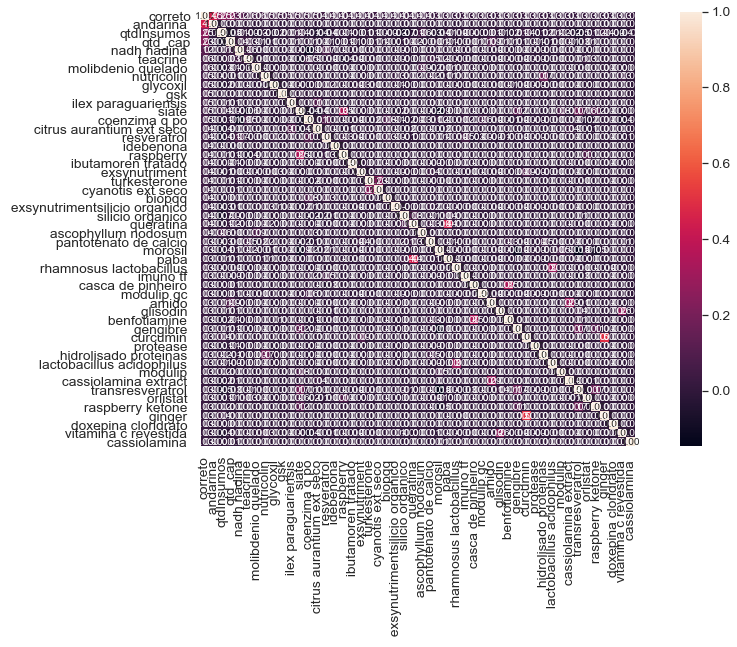

In [14]:
# Matriz de Correlação
k = 50 # número de variáveis para o HeatMap
plt.figure(figsize=(16,8))
corrmat = dff.corr()

# Selecionando as top 15 variáveis com maior correlação com preço
cols = corrmat.nlargest(k, 'correto')['correto'].index
cm = np.corrcoef(dff[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<br/><br/>
## Train/Test Split e Data Scaling

Separação das variáveis para treinamento
<br/><br/>

In [15]:
df_train = dff[cols]
cols

Index(['correto', ' andarina ', 'qtdInsumos', 'qtd_cap', ' nadh nadina ',
       ' teacrine ', ' molibdenio quelado ', ' nutricolin ', ' glycoxil ',
       ' gsk ', ' ilex paraguariensis ', ' siate ', ' coenzima q po ',
       ' citrus aurantium ext seco ', ' resveratrol ', ' idebenona ',
       ' raspberry ', ' ibutamoren tratado ', ' exsynutriment ',
       ' turkesterone ', ' cyanotis ext seco ', ' biopqq ',
       ' exsynutrimentsilicio organico ', ' silicio organico ', ' queratina ',
       ' ascophyllum nodosum ', ' pantotenato de calcio ', ' morosil ',
       ' paba ', ' rhamnosus lactobacillus ', ' imuno tf ',
       ' casca de pinheiro ', ' modulip gc ', ' amido ', ' glisodin ',
       ' benfotiamine ', ' gengibre ', ' curcumin ', ' protease ',
       ' hidrolisado proteinas ', ' lactobacillus acidophilus ', ' modulip ',
       ' cassiolamina extract ', ' transresveratrol ', ' orlistat ',
       ' raspberry ketone ', ' ginger ', ' doxepina cloridrato ',
       ' vitamina c rev

<br/><br/>
Separação das variáveis X e y para treinamento
<br/><br/>

In [16]:
X = df_train.drop(['correto'],axis=1)
y = df_train['correto']

In [17]:
# backup X e y originais
# X = dff.drop(['correto'],axis=1)
# y = (dff['correto'])



<br/><br/>
Uso do `train_test_split`para separar 70% do DataSet para Trineinamento e 30% para validação (teste)
<br/><br/>

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [19]:
# copiando os valores de `y_test` para validação do resultado dos modelos no final deste desafio.
y_test_validacao = y_test.copy()

<br/><br/>
Aplicando a **escala logaritmica** nos valores de `y_train` e `y_test` para evitar que os valores finais dos modelos tenham sinais negativos
<br/><br/>

In [20]:
y_train = np.log(y_train)
y_test = np.log(y_test)

<br/><br/>
Aplicando Normalização
<br/><br/>

In [21]:
# Aplicando Normalização

# y_train= y_train.values.reshape(-1,1)
# y_test= y_test.values.reshape(-1,1)

# scaling_X = MinMaxScaler()
# scaling_y = MinMaxScaler()

# scaling_X.fit_transform(X_train)
# scaling_X.fit_transform(X_test)
# scaling_y.fit_transform(y_train)
# scaling_y.fit_transform(y_test)

<br/><br/>
Aplicando a Padronização (Standardization) para transformar todos os valores entre -1 e 1.
<br/><br/>

In [22]:
# Aplicando Standardization

y_train= y_train.values.reshape(-1,1)
y_test= y_test.values.reshape(-1,1)

sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)
y_train = sc_X.fit_transform(y_train)
y_test = sc_y.fit_transform(y_test)

<br/><br/>
# Modelagem
<br/><br/>
## Regressão Linear

In [23]:
lm = LinearRegression()

lm.fit(X_train,y_train)
print(lm)

LinearRegression()


In [24]:
predictions = lm.predict(X_test)
predictions= predictions.reshape(-1,1)

<br/><br/>
Gráficos entre o valor de Y de teste e Y previsto
<br/><br/>

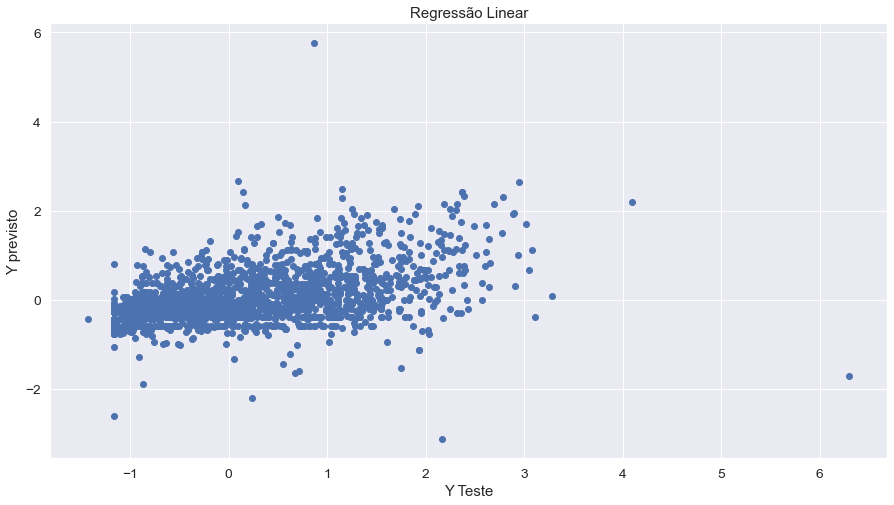

In [25]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,predictions)
plt.title('Regressão Linear')
plt.xlabel('Y Teste')
plt.ylabel('Y previsto')
plt.show()

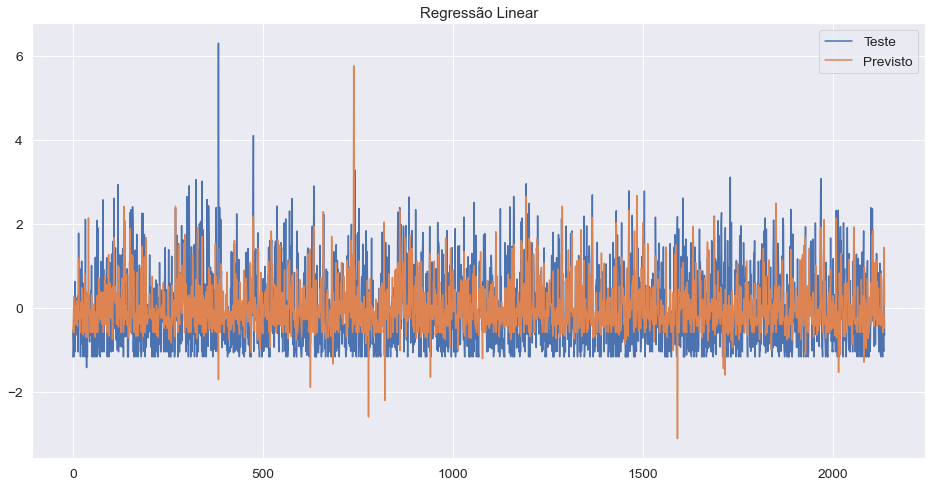

In [26]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Teste')
plt.plot(predictions, label = 'Previsto')
plt.title('Regressão Linear')
plt.legend()
plt.show()

<br/><br/>
Métricas de avaliação do resultado do modelo de **Regressão Linear**
<br/><br/>

In [27]:
# Definição do R^2 ajustado
def r2_ajustado(y_test, predictions):
    adj_r2 = (1 - ((1 - r2_score(y_test, predictions)) * (len(y_test) - 1)) / 
    (len(y_test) - X_train.shape[1] - 1))
    return adj_r2

print('Regressão Linear MAE:', metrics.mean_absolute_error(y_test, predictions))
print('Regressão Linear MSE:', metrics.mean_squared_error(y_test, predictions))
print('Regressão Linear RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('Regressão Linear R2 score', r2_score(y_test, predictions))
print('Regressão Linear R2 ajustado', r2_ajustado(y_test, predictions))

Regressão Linear MAE: 0.6875852071886496
Regressão Linear MSE: 0.7468588464888047
Regressão Linear RMSE: 0.8642099550970266
Regressão Linear R2 score 0.25314115351119526
Regressão Linear R2 ajustado 0.2356058954958855


<br/><br/>
## Gradient Boosting Regression

In [28]:
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

C:\Users\ivanb\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingRegressor(learning_rate=0.05, max_depth=4)

In [29]:
clf_pred=clf.predict(X_test)
clf_pred= clf_pred.reshape(-1,1)

<br/><br/>
Gráficos entre o valor de Y de teste e Y previsto do **Gradient Boosting Regression**
<br/><br/>

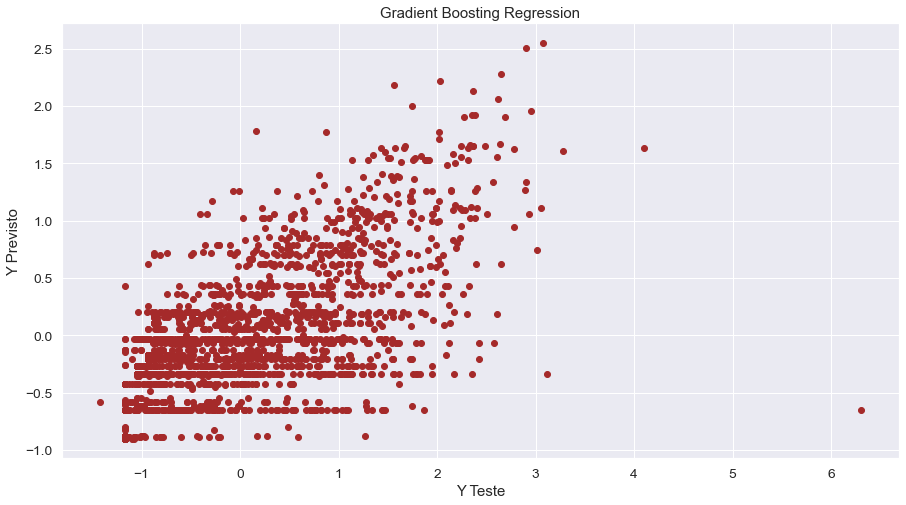

In [30]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,clf_pred, c= 'brown')
plt.title('Gradient Boosting Regression')
plt.xlabel('Y Teste')
plt.ylabel('Y Previsto')
plt.show()

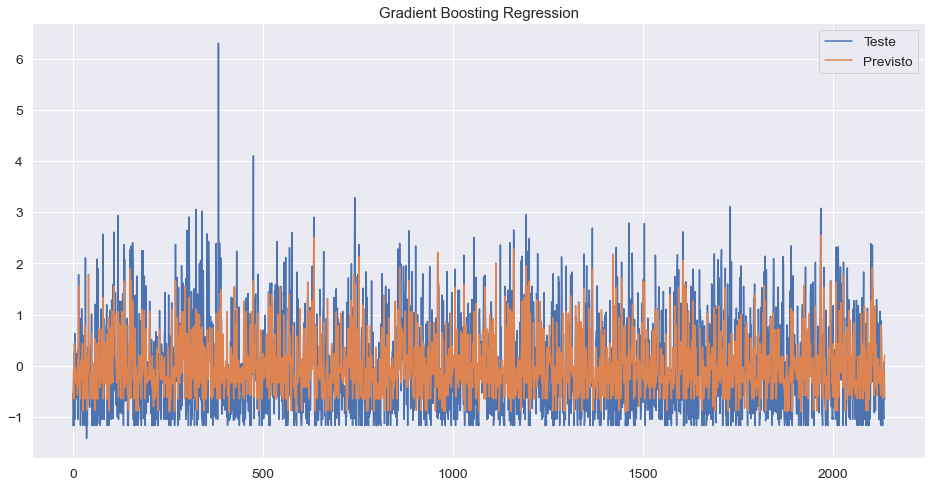

In [31]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Teste')
plt.plot(clf_pred, label = 'Previsto')
plt.title('Gradient Boosting Regression')
plt.legend()
plt.show()

<br/><br/>
Métricas de avaliação do resultado do modelo de **Gradient Boosting Regression**
<br/><br/>

In [32]:
print('Gradient Boosting Regression MAE:', metrics.mean_absolute_error(y_test, clf_pred))
print('Gradient Boosting Regression MSE:', metrics.mean_squared_error(y_test, clf_pred))
print('Gradient Boosting Regression RMSE:', np.sqrt(metrics.mean_squared_error(y_test, clf_pred)))
print('Gradient Boosting Regression R2 score:', r2_score(y_test, clf_pred))
print('Gradient Boosting Regression R2 ajustado', r2_ajustado(y_test, clf_pred))

Gradient Boosting Regression MAE: 0.6078454636446761
Gradient Boosting Regression MSE: 0.5785752741979121
Gradient Boosting Regression RMSE: 0.7606413571440303
Gradient Boosting Regression R2 score: 0.4214247258020879
Gradient Boosting Regression R2 ajustado 0.4078405435137804


<br/><br/>
## Decison Tree Regression

In [33]:
dtreg = DecisionTreeRegressor(random_state = 100)
dtreg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=100)

In [34]:
dtr_pred = dtreg.predict(X_test)
dtr_pred= dtr_pred.reshape(-1,1)

<br/><br/>
Gráficos entre o valor de Y de teste e Y previsto do **Decision Tree Regressor**
<br/><br/>

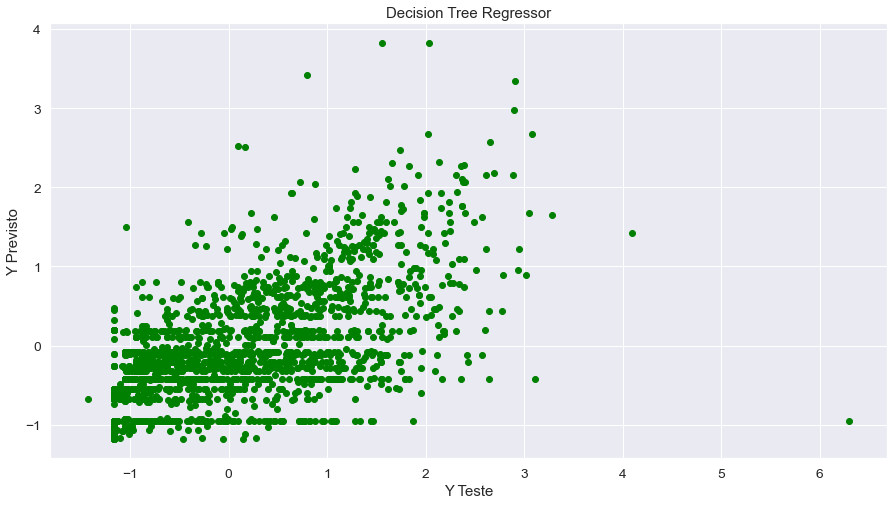

In [35]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,dtr_pred,c='green')
plt.title('Decision Tree Regressor')
plt.xlabel('Y Teste')
plt.ylabel('Y Previsto')
plt.show()

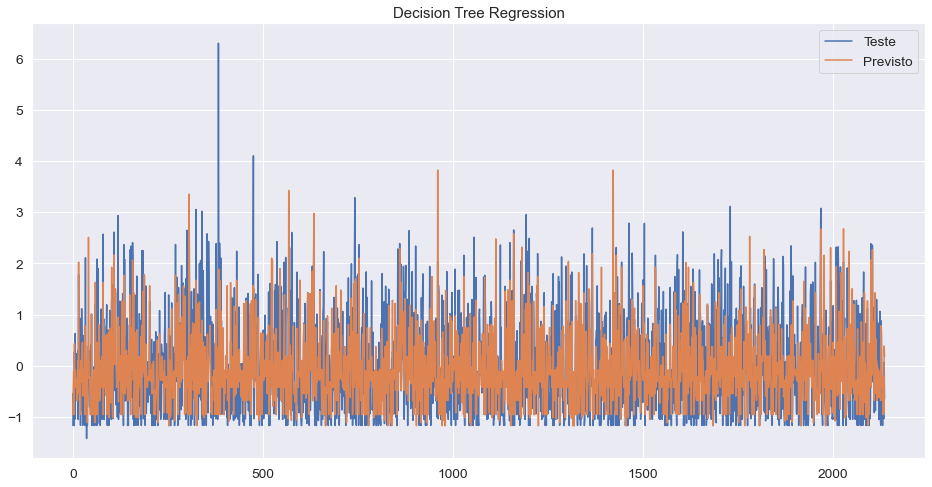

In [36]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Teste')
plt.plot(dtr_pred, label = 'Previsto')
plt.title('Decision Tree Regression')
plt.legend()
plt.show()

<br/><br/>
Métricas de avaliação do resultado do modelo de **Decision Tree Regression**
<br/><br/>

In [37]:
print('Decision Tree Regression MAE:', metrics.mean_absolute_error(y_test, dtr_pred))
print('Decision Tree Regression MSE:', metrics.mean_squared_error(y_test, dtr_pred))
print('Decision Tree Regression RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtr_pred)))
print('Decision Tree Regression R2 score', r2_score(y_test, dtr_pred))
print('Decision Tree Regression R2 ajustado', r2_ajustado(y_test, dtr_pred))

Decision Tree Regression MAE: 0.6128071625534902
Decision Tree Regression MSE: 0.6421623290122891
Decision Tree Regression RMSE: 0.8013503160368062
Decision Tree Regression R2 score 0.3578376709877109
Decision Tree Regression R2 ajustado 0.3427605487444899


<br/><br/>
## Support Vector Machine Regression

In [38]:
svr = SVR(kernel = 'rbf')
svr.fit(X_train, y_train)

C:\Users\ivanb\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR()

In [39]:
svr_pred = svr.predict(X_test)
svr_pred= svr_pred.reshape(-1,1)

<br/><br/>
Gráficos entre o valor de Y de teste e Y previsto do **Support Vector Machine Regression**
<br/><br/>

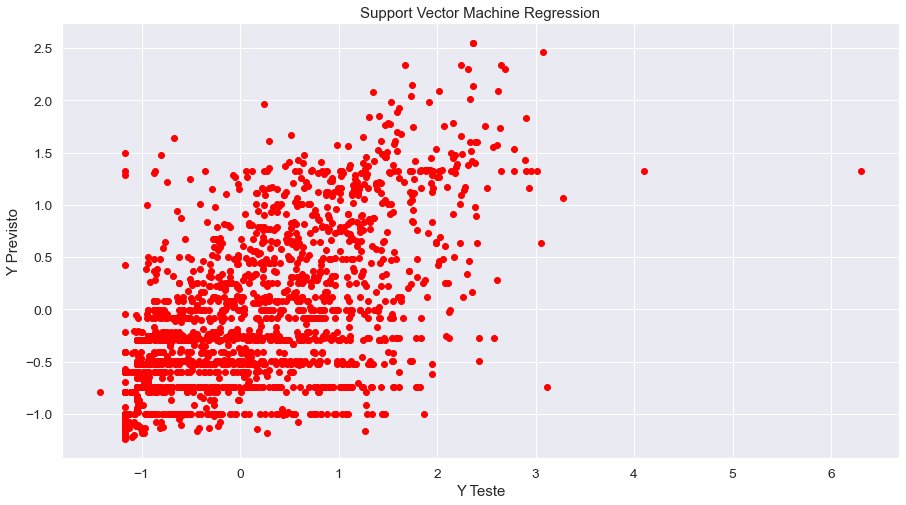

In [40]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,svr_pred, c='red')
plt.title('Support Vector Machine Regression')
plt.xlabel('Y Teste')
plt.ylabel('Y Previsto')
plt.show()

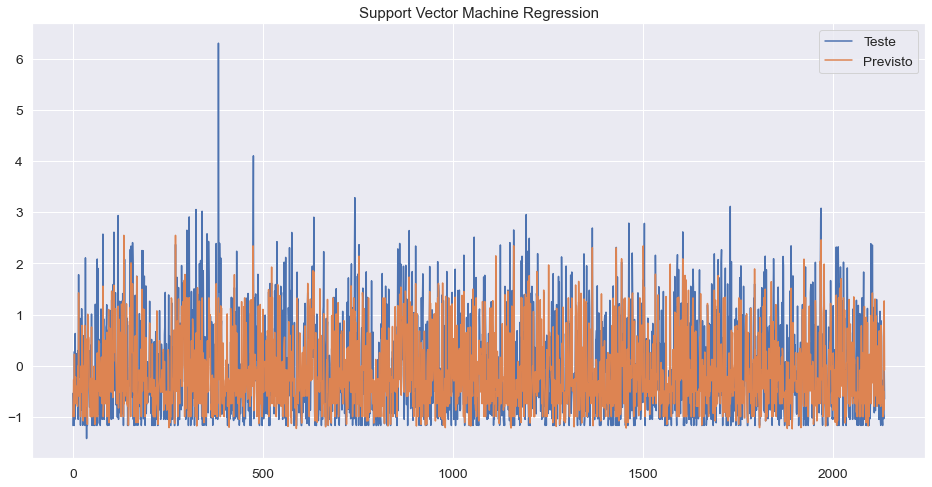

In [41]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Teste')
plt.plot(svr_pred, label = 'Previsto')
plt.title('Support Vector Machine Regression')
plt.legend()
plt.show()

<br/><br/>
Métricas de avaliação do resultado do modelo de **Support Vector Machine Regression**
<br/><br/>

In [42]:
print('Support Vector Machine Regression MAE:', metrics.mean_absolute_error(y_test, svr_pred))
print('Support Vector Machine Regression MSE:', metrics.mean_squared_error(y_test, svr_pred))
print('Support Vector Machine Regression RMSE:', np.sqrt(metrics.mean_squared_error(y_test, svr_pred)))
print('Support Vector Machine Regression R2 score', r2_score(y_test, svr_pred))
print('Support Vector Machine Regression R2 ajustado', r2_ajustado(y_test, svr_pred))

Support Vector Machine Regression MAE: 0.5901326805784981
Support Vector Machine Regression MSE: 0.6221245883478921
Support Vector Machine Regression RMSE: 0.7887487485555157
Support Vector Machine Regression R2 score 0.3778754116521079
Support Vector Machine Regression R2 ajustado 0.363268749060327


<br/><br/>
## Random Forest Regressor

In [43]:
rfr = RandomForestRegressor(n_estimators = 100, random_state = 0)
rfr.fit(X_train, y_train)

<ipython-input-43-664918805d82>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


RandomForestRegressor(random_state=0)

In [44]:
rfr_pred= rfr.predict(X_test)
rfr_pred = rfr_pred.reshape(-1,1)

<br/><br/>
Gráficos entre o valor de Y de teste e Y previsto do **Random Forest Regressor**
<br/><br/>

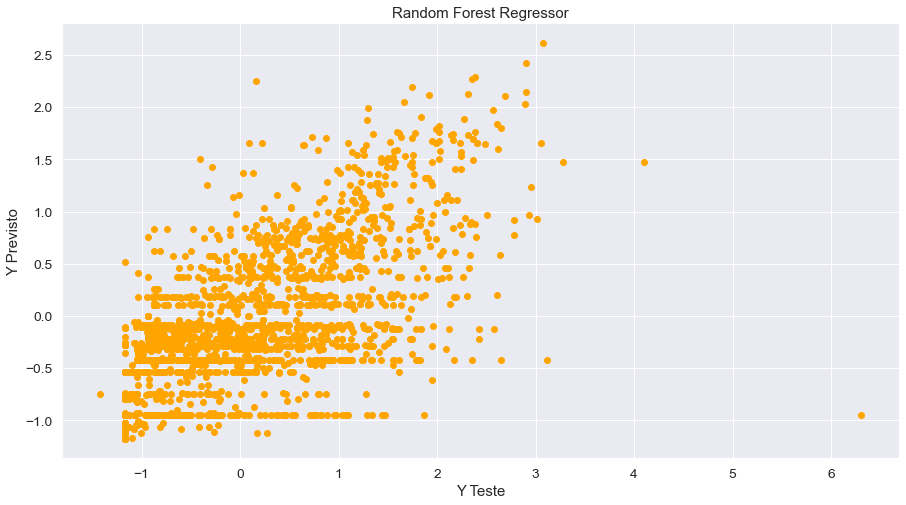

In [45]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,rfr_pred, c='orange')
plt.title('Random Forest Regressor')
plt.xlabel('Y Teste')
plt.ylabel('Y Previsto')
plt.show()

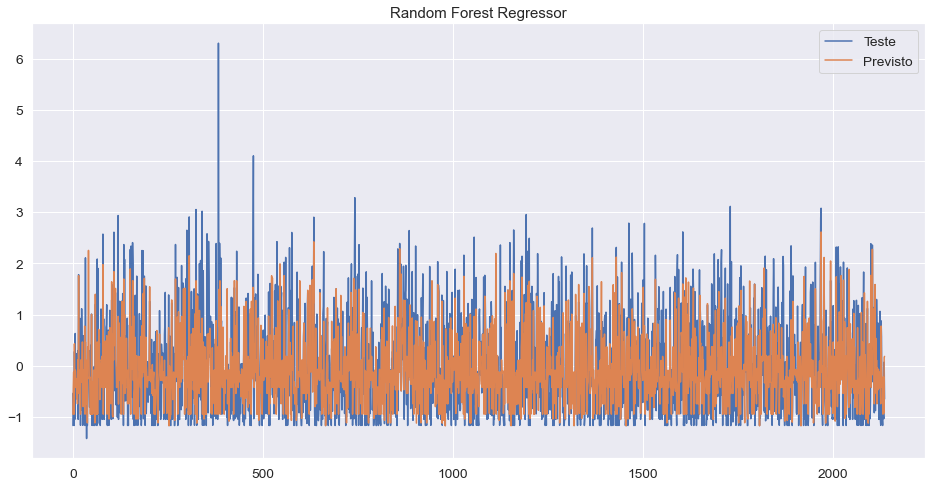

In [46]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Teste')
plt.plot(rfr_pred, label = 'Previsto')
plt.title('Random Forest Regressor')
plt.legend()
plt.show()


<br/><br/>
Métricas de avaliação do resultado do modelo de **Random Forest Regressor**
<br/><br/>

In [47]:
print('Random Forest Regressor MAE:', metrics.mean_absolute_error(y_test, rfr_pred))
print('Random Forest Regressor MSE:', metrics.mean_squared_error(y_test, rfr_pred))
print('Random Forest Regressor RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)))
print('Random Forest Regressor R2 score', r2_score(y_test, rfr_pred))
print('Random Forest Regressor R2 ajustado', r2_ajustado(y_test, rfr_pred))

Random Forest Regressor MAE: 0.5884479465672409
Random Forest Regressor MSE: 0.5946422767422558
Random Forest Regressor RMSE: 0.7711305186168265
Random Forest Regressor R2 score 0.4053577232577442
Random Forest Regressor R2 ajustado 0.3913963089978638


<br/><br/>
## Neural Network Regression

In [48]:
n_features = X.shape[1]

model = Sequential()
model.add(Dense(20, input_dim=n_features, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)
yhat = model.predict(X_test)
yhat= yhat.reshape(-1,1)

<br/><br/>
Gráficos entre o valor de Y de teste e Y previsto do **Neural Network Regression**
<br/><br/>

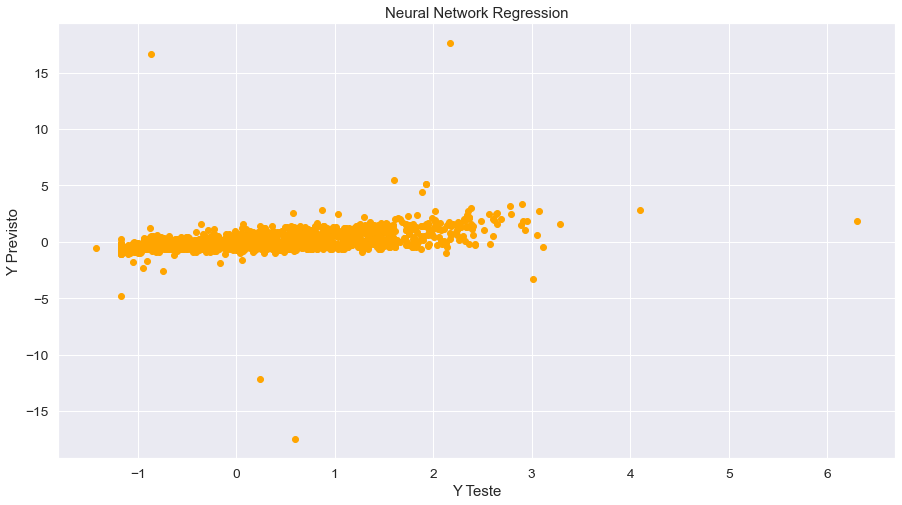

In [49]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,yhat, c='orange')
plt.title('Neural Network Regression')
plt.xlabel('Y Teste')
plt.ylabel('Y Previsto')
plt.show()

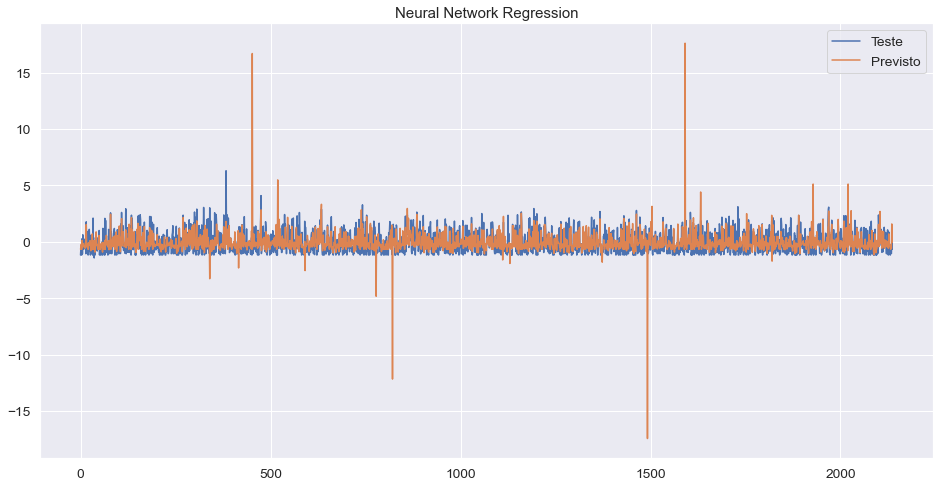

In [50]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Teste')
plt.plot(yhat, label = 'Previsto')
plt.title('Neural Network Regression')
plt.legend()
plt.show()

<br/><br/>
Métricas de avaliação do resultado do modelo de **Neural Network Regression**
<br/><br/>

In [51]:
print('Neural Network Regression MAE:', metrics.mean_absolute_error(y_test, yhat))
print('Neural Network Regression MSE:', metrics.mean_squared_error(y_test, yhat))
print('Neural Network Regression RMSE:', np.sqrt(metrics.mean_squared_error(y_test, yhat)))
print('Neural Network Regression R2 score', r2_score(y_test, yhat))
print('Neural Network Regression R2 ajustado', r2_ajustado(y_test, yhat))

Neural Network Regression MAE: 0.6340415638671998
Neural Network Regression MSE: 1.08780575315563
Neural Network Regression RMSE: 1.0429792678455454
Neural Network Regression R2 score -0.08780575315563
Neural Network Regression R2 ajustado -0.11334599364658637


<br/><br/>
## XGBoost

In [52]:
df_XGBoost_model = XGBRegressor(random_state=1, n_estimators=1000, learning_rate=0.05)
df_XGBoost_model.fit(X_train, y_train, 
             early_stopping_rounds=25, 
             eval_set=[(X_test, y_test)],
             verbose=False)

XGBoost_predictions = df_XGBoost_model.predict(X_test)
XGBoost_predictions= XGBoost_predictions.reshape(-1,1)

<br/><br/>
Gráficos entre o valor de Y de teste e Y previsto do **XGBoost**
<br/><br/>

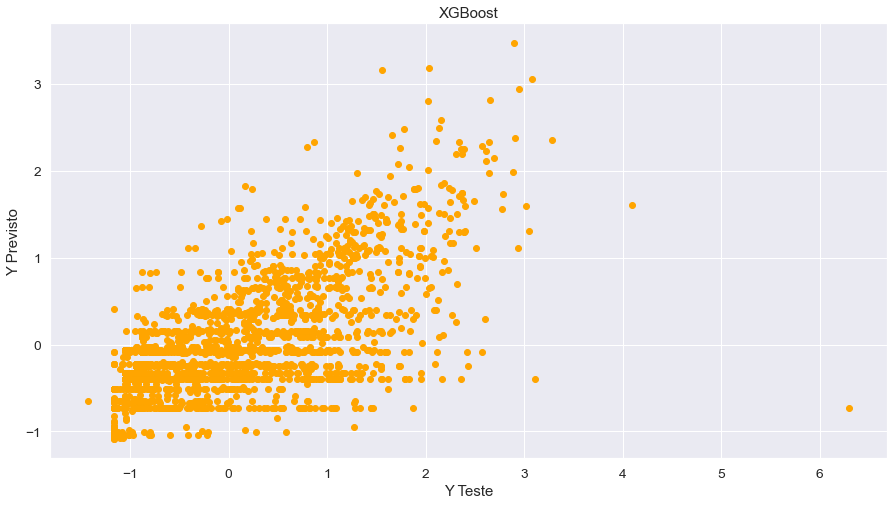

In [53]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,XGBoost_predictions, c='orange')
plt.title('XGBoost')
plt.xlabel('Y Teste')
plt.ylabel('Y Previsto')
plt.show()

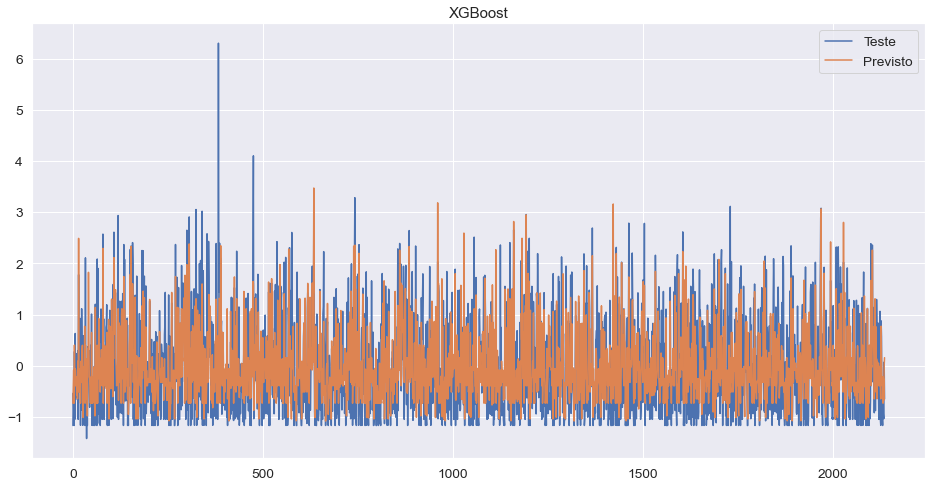

In [54]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Teste')
plt.plot(XGBoost_predictions, label = 'Previsto')
plt.title('XGBoost')
plt.legend()
plt.show()

In [55]:
print('XGBoost MAE:', metrics.mean_absolute_error(y_test, XGBoost_predictions))
print('XGBoost MSE:', metrics.mean_squared_error(y_test, XGBoost_predictions))
print('XGBoost RMSE:', np.sqrt(metrics.mean_squared_error(y_test, XGBoost_predictions)))
print('XGBoost R2 score', r2_score(y_test, XGBoost_predictions))
print('XGBoost R2 ajustado', r2_ajustado(y_test, XGBoost_predictions))

XGBoost MAE: 0.5707450609315438
XGBoost MSE: 0.5421095262732747
XGBoost RMSE: 0.7362808745806689
XGBoost R2 score 0.4578904737267253
XGBoost R2 ajustado 0.4451624589747414


<br/><br/>
# Comparação entre os modelos

<br/><br/>
Criação de um DataFrame `comparacao` que recebe os valores das métricas dos modelos

In [56]:
# Criação de um dicionário que contenha os valores necessários para compor o DataFrame
# Eu poderia ter feito de uma maneira mais fácil e rápida este dicionário
comp = {'MAE':[metrics.mean_absolute_error(y_test, predictions),
               metrics.mean_absolute_error(y_test, clf_pred),
               metrics.mean_absolute_error(y_test, dtr_pred), 
               metrics.mean_absolute_error(y_test, svr_pred),
               metrics.mean_absolute_error(y_test, rfr_pred),
               metrics.mean_absolute_error(y_test, yhat),
               metrics.mean_absolute_error(y_test, XGBoost_predictions)],
        'MSE':[metrics.mean_squared_error(y_test, predictions),
               metrics.mean_squared_error(y_test, clf_pred),
               metrics.mean_squared_error(y_test, dtr_pred),
               metrics.mean_squared_error(y_test, svr_pred),
               metrics.mean_squared_error(y_test, rfr_pred),
               metrics.mean_squared_error(y_test, yhat),
               metrics.mean_squared_error(y_test, XGBoost_predictions)],   
       'RMSE':[np.sqrt(metrics.mean_squared_error(y_test, predictions)),
               np.sqrt(metrics.mean_squared_error(y_test, clf_pred)),
               np.sqrt(metrics.mean_squared_error(y_test, dtr_pred)), 
               np.sqrt(metrics.mean_squared_error(y_test, svr_pred)),
               np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)),
               np.sqrt(metrics.mean_squared_error(y_test, yhat)),
               np.sqrt(metrics.mean_squared_error(y_test, XGBoost_predictions))],
   'R2 score':[r2_score(y_test, predictions),
               r2_score(y_test, clf_pred),
               r2_score(y_test, dtr_pred), 
               r2_score(y_test, svr_pred),
               r2_score(y_test, rfr_pred),
               r2_score(y_test, yhat),
               r2_score(y_test, XGBoost_predictions)],
'R2 ajustado':[r2_ajustado(y_test, predictions),
               r2_ajustado(y_test, clf_pred),
               r2_ajustado(y_test, dtr_pred), 
               r2_ajustado(y_test, svr_pred),
               r2_ajustado(y_test, rfr_pred),
               r2_ajustado(y_test, yhat),
               r2_ajustado(y_test, XGBoost_predictions)]}
 
# Criação de um DataFrame 'comparacao'
comparacao = pd.DataFrame(comp, index =['Regressão Linear',
                                'Gradient Boost',
                                'Decision Tree',
                                'Support Vector Machine',
                                'Random Forest',
                                'Neural Network',
                                'XGBoost'])

# Transpor o DataFrame para melhor visualização
comparacao.T

,Regressão Linear,Gradient Boost,Decision Tree,Support Vector Machine,Random Forest,Neural Network,XGBoost
MAE,0.687585,0.607845,0.612807,0.590133,0.588448,0.634042,0.570745
MSE,0.746859,0.578575,0.642162,0.622125,0.594642,1.087806,0.542110
RMSE,0.864210,0.760641,0.801350,0.788749,0.771131,1.042979,0.736281
R2 score,0.253141,0.421425,0.357838,0.377875,0.405358,-0.087806,0.457890
R2 ajustado,0.235606,0.407841,0.342761,0.363269,0.391396,-0.113346,0.445162


In [57]:
# Eu poderia ter feito de uma maneira mais fácil e rápida este array
error_rate_MAE = np.array([metrics.mean_absolute_error(y_test, predictions),
                     metrics.mean_absolute_error(y_test, clf_pred),
                     metrics.mean_absolute_error(y_test, dtr_pred),
                     metrics.mean_absolute_error(y_test, svr_pred),
                     metrics.mean_absolute_error(y_test, rfr_pred),
                     metrics.mean_absolute_error(y_test, yhat),
                     metrics.mean_absolute_error(y_test, XGBoost_predictions)])

error_rate_MSE = np.array([metrics.mean_squared_error(y_test, predictions),
                     metrics.mean_squared_error(y_test, clf_pred),
                     metrics.mean_squared_error(y_test, dtr_pred),
                     metrics.mean_squared_error(y_test, svr_pred),
                     metrics.mean_squared_error(y_test, rfr_pred),
                     metrics.mean_squared_error(y_test, yhat),
                     metrics.mean_squared_error(y_test, XGBoost_predictions)])

error_rate_RMSE = np.array([np.sqrt(metrics.mean_squared_error(y_test, predictions)),
                     np.sqrt(metrics.mean_squared_error(y_test, clf_pred)),
                     np.sqrt(metrics.mean_squared_error(y_test, dtr_pred)),
                     np.sqrt(metrics.mean_squared_error(y_test, svr_pred)),
                     np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)),
                     np.sqrt(metrics.mean_squared_error(y_test, yhat)),
                     np.sqrt(metrics.mean_squared_error(y_test, XGBoost_predictions))])

error_rate_R2score = np.array([r2_score(y_test, predictions),
                     r2_score(y_test, clf_pred),
                     r2_score(y_test, dtr_pred),
                     r2_score(y_test, svr_pred),
                     r2_score(y_test, rfr_pred),
                     r2_score(y_test, yhat),
                     r2_score(y_test, XGBoost_predictions)])

error_rate_R2_mod = np.array([r2_ajustado(y_test, predictions),
                     r2_ajustado(y_test, clf_pred),
                     r2_ajustado(y_test, dtr_pred),
                     r2_ajustado(y_test, svr_pred),
                     r2_ajustado(y_test, rfr_pred),
                     r2_ajustado(y_test, yhat),
                     r2_ajustado(y_test, XGBoost_predictions)])

<br/><br/> 
### Gráfico de comparação entre as métricas dos modelos

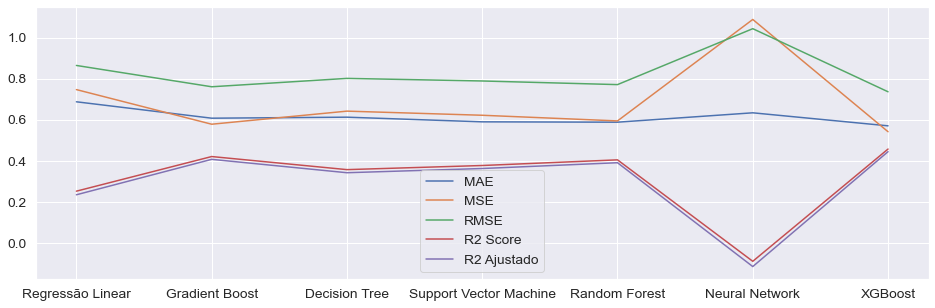

In [58]:
plt.figure(figsize=(16,5))
plt.plot(error_rate_MAE, label = 'MAE')
plt.plot(error_rate_MSE , label = 'MSE')
plt.plot(error_rate_RMSE , label = 'RMSE')
plt.plot(error_rate_R2score , label = 'R2 Score')
plt.plot(error_rate_R2_mod , label = 'R2 Ajustado')
x = np.array([0,1,2,3,4,5,6])
my_ticks = ['Regressão Linear','Gradient Boost','Decision Tree','Support Vector Machine','Random Forest','Neural Network','XGBoost']
plt.xticks(x, my_ticks)
plt.legend()
plt.show()

<br/><br/> Claramente os modelos com menor MAE, MSE e RMSE são os com maiores R2 e R2 ajustados. Estes modelos são o **Gradient Boost** e **XGBoost**

In [59]:
# Backup com standization e log

# test_prediction_svr =sc_y.inverse_transform(svr_pred)

# test_prediction_svr = pd.DataFrame(test_prediction_svr, columns=['calculado_ivan'])
# test_prediction_svr['calculado_ivan'] = np.exp(test_prediction_svr['calculado_ivan'])


<br/><br/>
**Invertendo a transformação Standardize e aplicando exponencial** nos resultados para recuperar os valores corretos das predições.

In [60]:
# Eu poderia ter feito estas associações de um jeito mais fácil
test_prediction_rl_i =sc_y.inverse_transform(predictions)
test_prediction_clf_i =sc_y.inverse_transform(clf_pred)
test_prediction_dtr_i =sc_y.inverse_transform(dtr_pred)
test_prediction_svr_i =sc_y.inverse_transform(svr_pred)
test_prediction_rfr_i =sc_y.inverse_transform(rfr_pred)
test_prediction_nn_i =sc_y.inverse_transform(yhat)
test_prediction_xg_i =sc_y.inverse_transform(XGBoost_predictions)

test_prediction_rl_i =np.exp(test_prediction_rl_i)
test_prediction_clf_i =np.exp(test_prediction_clf_i)
test_prediction_dtr_i =np.exp(test_prediction_dtr_i)
test_prediction_svr_i =np.exp(test_prediction_svr_i)
test_prediction_rfr_i =np.exp(test_prediction_rfr_i)
test_prediction_nn_i =np.exp(test_prediction_nn_i)
test_prediction_xg_i =np.exp(test_prediction_xg_i)

In [61]:
# Eu poderia ter feito estas associações de um jeito mais fácil
test_prediction_rl = pd.DataFrame(test_prediction_rl_i, columns=['calculado_RL'])
test_prediction_clf = pd.DataFrame(test_prediction_clf_i, columns=['calculado_Gradient Boost'])
test_prediction_dtr = pd.DataFrame(test_prediction_dtr_i, columns=['calculado_Decision Tree'])
test_prediction_svr = pd.DataFrame(test_prediction_svr_i, columns=['calculado_SVM'])
test_prediction_rfr = pd.DataFrame(test_prediction_rfr_i, columns=['calculado_Random Forest'])
test_prediction_nn = pd.DataFrame(test_prediction_nn_i, columns=['calculado_Neural Network'])
test_prediction_xg = pd.DataFrame(test_prediction_xg_i, columns=['calculado_XGBoost'])

In [62]:
y_test_valid = pd.DataFrame(y_test_validacao)
y_test_valid = y_test_valid.reset_index(drop=True)
result = pd.concat([y_test_valid,
                    test_prediction_rl,
                    test_prediction_clf,
                    test_prediction_dtr,
                    test_prediction_svr,
                    test_prediction_rfr,
                    test_prediction_nn,
                    test_prediction_xg], axis=1)

<br/><br/>
### Resultado de todos os modelos em relação ao valor correto

In [63]:
result.head()

,correto,calculado_RL,calculado_Gradient Boost,calculado_Decision Tree,calculado_SVM,calculado_Random Forest,calculado_Neural Network,calculado_XGBoost
0,39.9,61.590419,58.743579,46.714904,45.359289,47.036667,58.299622,55.181633
1,63.9,71.031018,74.161109,69.486523,54.775055,69.350778,69.386360,71.061523
2,52.4,94.475196,90.385361,87.200867,77.838946,86.735787,81.468437,89.271477
3,39.9,61.590419,58.743579,46.714904,45.359289,47.036667,58.299622,55.181633
4,116.9,114.703380,131.560650,131.223521,112.399967,130.881580,104.979713,128.419022


<br/><br/>
# Resultado Final com os modelos mais assertivos (Gradient Boost e XGBoost)

In [64]:
resultado_final = result = pd.concat([y_test_valid,
                           test_prediction_clf,
                           test_prediction_xg], axis=1)
resultado_final.head()

,correto,calculado_Gradient Boost,calculado_XGBoost
0,39.9,58.743579,55.181633
1,63.9,74.161109,71.061523
2,52.4,90.385361,89.271477
3,39.9,58.743579,55.181633
4,116.9,131.560650,128.419022


<br/><br/>
Métricas dos modelos Gradient Boost e XGBoost após transformação para os valores reais

In [65]:
# Criação de um dicionário que contenha os valores necessários para compor o DataFrame
# Eu poderia ter feito de uma maneira mais fácil e rápida este dicionário
comp = {'MAE':[metrics.mean_absolute_error(y_test_valid, test_prediction_clf),
               metrics.mean_absolute_error(y_test_valid, test_prediction_xg)],
        'MSE':[metrics.mean_squared_error(y_test_valid, test_prediction_clf),
               metrics.mean_squared_error(y_test_valid, test_prediction_xg)],   
       'RMSE':[np.sqrt(metrics.mean_squared_error(y_test_valid, test_prediction_clf)),
               np.sqrt(metrics.mean_squared_error(y_test_valid, test_prediction_xg))],
   'R2 score':[r2_score(y_test_valid, test_prediction_clf),
               r2_score(y_test_valid, test_prediction_xg)],
'R2 ajustado':[r2_ajustado(y_test_valid, test_prediction_clf),
               r2_ajustado(y_test_valid, test_prediction_xg)]}
 
# Criação de um DataFrame 'comparacao'
comparacao_final = pd.DataFrame(comp, index =['Gradient Boost','XGBoost'])

# Transpor o DataFrame para melhor visualização
comparacao_final.T

,Gradient Boost,XGBoost
MAE,62.952597,59.435745
MSE,60752.097941,59818.440984
RMSE,246.479407,244.578088
R2 score,0.078103,0.092271
R2 ajustado,0.056458,0.070959
